<a href="https://colab.research.google.com/github/Fatimata01/Classification-d-images/blob/main/Radiographie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**KOINDA Fatimata**

**Modèle de classification d'images pour détecter la pneumonie à partir d'images radiographiques**

Selon l'OMS, chaque année, **plus de 150 millions** de personnes sont infectées par la pneumonie, **en particulier les enfants de moins de 5 ans**.

> 


Les radiographies pulmonaires sont actuellement la meilleure méthode disponible pour diagnostiquer la pneumonie et jouent donc un rôle crucial dans le diagnostic et la prestation de soins cliniques aux personnes touchées. Cependant, détecter la pneumonie dans les radiographies pulmonaires est une tâche difficile qui repose sur la disponibilité de radiologues experts. Les experts ne sont pas disponibles dans les régions éloignées ou la plupart des gens ne peuvent pas se le permettre. Dans de telles circonstances, automatiser la détection des maladies devient le besoin de l'heure.

> **Objectif**:Construire un modèle de classification d'images avec précision pour identifier si une personne a été infectée ou non par une pneumonie en regardant les images radiographiques thoraciques. La précision est vitale pour un tel modèle de classification d'images d'apprentissage automatique, car il s'agit d'une question de vie.









1.   **Chargement des bibliothèques nécéssaires**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import os
import glob
import cv2                 
import numpy as np 
import pandas as pd
from PIL import Image
from pathlib import Path
from keras.models import Sequential , Model,load_model
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.layers import Dropout , GlobalAveragePooling2D,Dense,Conv2D,Activation,Input,Flatten,MaxPooling2D
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from keras.callbacks import Callback,EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline





2.   **Description de la base de données**

La base de données est divisée en trois ensembles : **apprentissage, validation et test**;et chaque ensemble est constitué des images radiographiques de pneumonie et des images radiographiques normales.



In [ ]:
print(os.listdir("/content/drive/MyDrive/Colab Notebooks/radiographie"))

['test', 'train', 'val']


In [ ]:
data_dir=Path("/content/drive/MyDrive/Colab Notebooks/radiographie")
train_dir=data_dir/'train'
test_dir=data_dir/'test'
val_dir=data_dir/'val'

In [ ]:
def load_train():
  normal_cases_dir=train_dir/ 'NORMAL'
  pneumonia_cases_dir=train_dir/ 'PNEUMONIA'
  normal_cases=normal_cases_dir.glob('*.jpeg')
  pneumonia_cases=pneumonia_cases_dir.glob('*.jpeg')
  train_data=[]
  train_label=[]
  for img in normal_cases:
    train_data.append(img)
    train_label.append('NORMAL')

  for img in pneumonia_cases:
    train_data.append(img)
    train_label.append('PNEUMONIA')
  df=pd.DataFrame(train_data)
  df.columns=['images']
  df['labels']=train_label
  df=df.sample(frac=1).reset_index(drop=True)
  return df

In [ ]:
train_data=load_train()
train_data.shape

(4297, 2)

La base d'entrainement contient **4297** images.

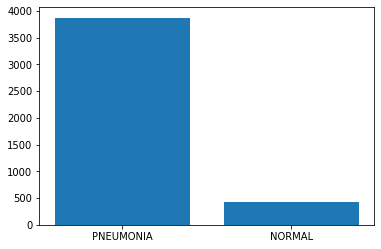

In [ ]:
plt.bar(train_data['labels'].value_counts().index,train_data['labels'].value_counts().values)
plt.show()

On constate que nos données sont **déséquilibrées**.En effet, le nombre d'images contenant une pneumonie est nettement supérieur au nombre d'images normales. Ce qui est souvent logique,car les personnes qui consultent un médecin pour une maladie en ont pour la plupart un.

In [ ]:
def plot(image_batch,label_batch):
  plt.figure(figsize=(10,5))
  for i in range(10):
    ax=plt.subplot(2,5,i+1)
    img=cv2.imread(str(image_batch[i]))
    img=cv2.resize(img,(224,224))
    plt.imshow(img)
    plt.title(label_batch[i])
    plt.axis("off")

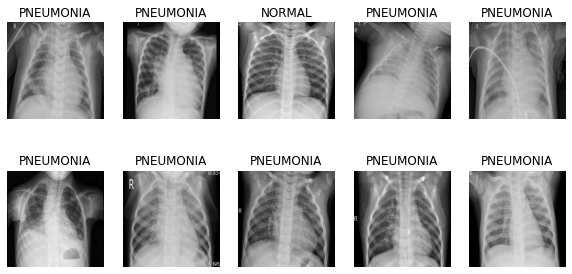

In [ ]:
plot(image_batch=train_data['images'],label_batch=train_data['labels'])



3. **Chargement de l'ensemble test et validation-Prétraitement des images**


*  Étant donné que les images sont de longueurs et de largeurs différentes, on va les redimensionner à 224 224,3.
*   Certaines images sont en niveaux de gris (1 canal), on va les convertir en 3 canaux

*   Les images lues à l'aide de cv2 sont au format BGR (par défaut), le convertir en RVB.






*   Normaliser les pixels de l'image en les divisant par 255.
*   to_categorical est utilisé pour convertir les étiquettes au format encodé one-hot.










In [ ]:
def prepare_and_load(isval=True):
  if isval==True:
    normal_dir=val_dir/'NORMAL'
    pneumonia_dir=val_dir/'PNEUMONIA'
  else:
    normal_dir=test_dir/'NORMAL'
    pneumonia_dir=test_dir/'PNEUMONIA'
  normal_cases=normal_dir.glob('*.jpeg')
  pneumonia_cases=pneumonia_dir.glob('*.jpeg')
  data,labels=([] for x in range(2))
  def prepare(case):
    for img in case:
      img=cv2.imread(str(img))
      img=cv2.resize(img,(224,224))
      if img.shape[2]==1:
        img=np.dstack([img,img,img])
      img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      img=img.astype(np.float32)/255
      if case==normal_cases:
        label=to_categorical(0,num_classes=2)
      else:
        label=to_categorical(1,num_classes=2)
      data.append(img)
      labels.append(label)
    return data,labels
  prepare(normal_cases)
  d,l=prepare(pneumonia_cases)
  d=np.array(d)
  l=np.array(l)
  return d,l



    



In [ ]:
val_data,val_labels=prepare_and_load(isval=True)
test_data,test_labels=prepare_and_load(isval=False)
print('Number of test images --->',len(test_data))
print('Number of validation images --->',len(val_data))


Number of test images ---> 634
Number of validation images ---> 16


Nous avons **16 images à valider et 634 images à tester**.

La fonction ci-dessus a pour but de générer les images par lot pour la formation.En effet on sait que la formation se déroule par lots. Le modèle prend le premier lot, le fait passer dans le réseau, une perte est calculée au final, puis les gradients remontent pour mettre à jour les paramètres du réseau. Ce processus est répété jusqu'à ce qu'on atteigne la perte souhaitée et que l'entraînement s'arrête.

In [ ]:
def data_gen(data,batch_size):
  n=len(data)
  steps=n//batch_size

  batch_data=np.zeros((batch_size,224,224,3),dtype=np.float32)
  batch_labels=np.zeros((batch_size,2),dtype=np.float32)

  indices=np.arange(n)

  i=0
  while True:
    np.random.shuffle(indices)
    count=0
    next_batch=indices[(i*batch_size):(i+1)*batch_size]
    for j,idx in enumerate(next_batch):
      img_name=data.iloc[idx]['images']
      label=data.iloc[idx]['labels']
      if label=='NORMAL':
        label=0
      else:
        label=1

      encoded_label=to_categorical(label,num_classes=2)

      img=cv2.imread(str(img_name))
      img=cv2.resize(img,(224,224))
      if img.shape[2]==1:
        img=np.dstack([img,img,img])
      

      orig_img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      orig_img=img.astype(np.float32)/255

      batch_data[count]=orig_img
      batch_labels[count]=encoded_label

      count+=1
      if count==batch_size-1:
        break
    
    i+=1
    yield batch_data,batch_labels

    if i>=steps:
      i=0
     
    
  
         


Une activation **ReLu** est appliquée après chaque convolution pour transformer les valeurs de sortie entre la plage 0 à 1.

In [ ]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(224,224,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

La **taille du lot** fait référence au nombre d'images transmises au réseau en une seule passe directe. D'autre part, le **nombre d'époques** détermine le nombre de fois que notre réseau traiterait l'ensemble des données d'entraînement. Le **nombre d'étapes** d'entraînement est le nombre d'étapes dans une époque et est calculé en divisant la taille de nos données d'entraînement par la taille du lot. 

In [ ]:
batch_size=16
nb_epochs=3

train_data_gen=data_gen(data=train_data,batch_size=batch_size)

nb_train_steps=train_data.shape[0]//batch_size

print("Number of training and validation steps:{} and {}".format(nb_train_steps,len(val_data)))

Number of training and validation steps:268 and 16


On a utilisé la **binary crossentropy** comme fonction de perte car nous n'avons que 2 classes. **Rmsprop**(Root Mean Square Propagation) sera notre fonction d'optimisation.

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
history=model.fit_generator(train_data_gen,epochs=nb_epochs,steps_per_epoch=nb_train_steps,validation_data=(val_data,val_labels))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/3
268/268 [==============================] - 336s 1s/step - loss: 0.2299 - accuracy: 0.8638 - val_loss: 0.7679 - val_accuracy: 0.6250
Epoch 2/3
268/268 [==============================] - 334s 1s/step - loss: 0.0911 - accuracy: 0.9037 - val_loss: 0.8571 - val_accuracy: 0.6875
Epoch 3/3
268/268 [==============================] - 333s 1s/step - loss: 0.0801 - accuracy: 0.9181 - val_loss: 3.2835 - val_accuracy: 0.5000


on constate que notre précision de validation n'est pas bonne.

**L'apprentissage par transfert** est une technique consistant à utiliser des réseaux de neurones pré-entraînés qui sont entraînés sur des milliards d'images (comme Alexnet, Inception net, VGG16) sur une tâche différente en modifiant la dernière couche de classification.

In [ ]:
def vgg16_model(num_classes=None):
  model2=VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3))
  x=Dense(1024,activation='relu')(model2.layers[-4].output)
  x=Dropout(0.7)(x)
  x=Dense(512,activation='relu')(x)
  x=Dropout(0.5)(x)
  x=Dense(2,activation='softmax')(x)
  model2=Model(model2.input,x)

  return model2


La taille d'entrée reste la même (224, 224, 3);  Après le dernier bloc de convolution, on a ajouté **3 couches Dense avec Dropout** pour régulariser le modèle et éviter le surapprentissage. 


In [ ]:
vgg_conv=vgg16_model(2)
for layer in vgg_conv.layers[:-10]:
  layer.trainable=False


Cette fois, on a choisi Adam comme optimiseur.

In [ ]:
opt=Adam(lr=0.0001,decay=0.00001)
vgg_conv.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=opt)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history=vgg_conv.fit_generator(train_data_gen,epochs=nb_epochs,steps_per_epoch=nb_train_steps,validation_data=(val_data,val_labels),class_weight={0:1.0, 1:0.4})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/3
268/268 [==============================] - 2998s 11s/step - loss: 0.1022 - accuracy: 0.8979 - val_loss: 0.8398 - val_accuracy: 0.8750
Epoch 2/3
268/268 [==============================] - 2981s 11s/step - loss: 0.0342 - accuracy: 0.9368 - val_loss: 2.7849 - val_accuracy: 0.6875
Epoch 3/3
268/268 [==============================] - 2984s 11s/step - loss: 0.0211 - accuracy: 0.9468 - val_loss: 5.6900 - val_accuracy: 0.6250


On remarque que la précision de validation est de **0,6250** avec ce modèle. Une autre chose importante qui doit être abordée ici est le déséquilibre des données. on a fourni des poids de classe pendant la formation pour compenser le déséquilibre des données.

In [ ]:
loss,acc=vgg_conv.evaluate(test_data,test_labels,batch_size=16)
print('Loss and accuracy',loss,'&',acc)

40/40 [==============================] - 332s 8s/step - loss: 1.7341 - accuracy: 0.8060
Loss and accuracy 1.7341301441192627 & 0.8059936761856079


La précision semble être bonne. Mais vu que nos données sont déséquilibrées, la précision n'est pas une mesure très fiable de la performance.

In [ ]:
pred=vgg_conv.predict(test_data,batch_size=16)
pred=np.argmax(pred,axis=-1)

labels=np.argmax(test_labels,axis=-1)
from sklearn.metrics import classification_report
print(classification_report(labels,pred))

              precision    recall  f1-score   support

           0       0.99      0.50      0.66       244
           1       0.76      1.00      0.86       390

    accuracy                           0.81       634
   macro avg       0.88      0.75      0.76       634
weighted avg       0.85      0.81      0.79       634





*   La **précision** dans notre cas, est le nombre de personnes ayant réellement une pneumonie divisé par toutes celles prédites par le modèle comme ayant une pneumonie.
*   Le **rappel**, quant à lui, est la fraction de personnes ayant réellement une pneumonie et qui sont prédites positives par le modèle par rapport au nombre total de personnes ayant une pneumonie. Il mesure **le potentiel d'un test à reconnaître les patients atteints de la maladie.**




*   Le **score F1** n'est que la moyenne harmonique de la précision et du rappel.

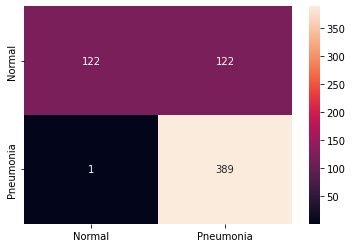

In [ ]:
import seaborn as sns
cm=confusion_matrix(labels,pred)
sns.heatmap(cm,annot=True,fmt='g',xticklabels=['Normal','Pneumonia'],yticklabels=['Normal','Pneumonia'])